# Import required libraries and functions

In [ ]:
### Code adapted from Hands-On Machine Learning (Aurelien Geron) and Machine Learning in Finance (Matthew Dixon, Igor Halperin and Paul Bilokon)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from sklearn import preprocessing
import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Globals
transaction_cost = .001
crypto_params = ['BTC-USD', 'ETH-USD']
time_period_params = ['_hr_24', '_hr_1']

import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

def naive_baseline(y_train):
    y_naive = np.roll(y_train, 1)
    print(np.mean(keras.losses.mean_squared_error(y_train, y_naive)))
    return y_naive

# split dataset into 1-t% training, t test
def partition(df, t):
    split_index = int(len(df) * (1-t))

    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    return df_train, df_test

def sliding_window(data, n_steps):
    x = list()
    y = list()
    for i in range(len(data)):
        window_end = i + n_steps
        if window_end > len(data) - 1:
            break
        
        x_window = data.iloc[i:window_end, :-1]
        y_prediction = data.iloc[window_end - 1, -1]

        x.append(x_window)
        y.append(y_prediction)
    return np.array(x), np.array(y)

# force cpu only
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Parse raw data
Turn time series into supervised learning problem

In [ ]:
def label_trade(period_return):
    if(abs(period_return) <= transaction_cost):
        return 0
    elif period_return > transaction_cost:
        return 1
    else:
        return -1

In [ ]:
def label_raw(dataset):
    print(dataset)
    df = pd.read_csv(f'../data/raw/{dataset}.csv')

    # assumption: make decision at open of trading period
    # shift these cols
    shift_header = ['low', 'high', 'open','close', 'volume']
    for col in shift_header:
        new_header = f'last_{col}'
        df[new_header] = df[col].shift(1)
    
    # rename current observations
    df = df.rename(columns={'open':'current_open', 'close':'target_close'})

    # drop low, high, volume cols and rearrange remaining
    df = df[['time','last_low', 'last_high', 'last_open','last_close','last_volume', 'current_open', 'target_close']]

    # calculate period returns and label trade
    df['period_return'] = (df['target_close'].values - df['current_open'].values) / df['current_open'].values
    df['target_trade'] = df['period_return'].apply(label_trade)

    # assumptions:
    # perfect close prediction
    # end period in cash
    # 0 cost to short sell
    df['profit'] = df['period_return'] * df['target_trade'] * df['target_close'] * (1 - transaction_cost)
    df['profit'].sum()

    # save labeled dataset
    df.to_csv(f'../data/labeled_{dataset}.csv', header=True, index=False, mode='w')
    print(f'Saved to ../data/labeled_{dataset}.csv')

In [ ]:
for crypto in crypto_params:
    for time_period in time_period_params:
        dataset = crypto + time_period
        label_raw(dataset)

# Multivariate

## Import labeled dataset

In [16]:
# dataset = "BTC-USD_hr_24"
dataset = "ETH-USD_hr_24"
df = pd.read_csv(f'../data/labeled_{dataset}.csv', index_col=0)
df.index = pd.to_datetime(df.index, unit='s')
target = 'target_close'

df = df.dropna()

use_features = ['last_low', 'last_high', "last_open", "last_close","last_volume", "current_open", target] # continuous input
n_features = len(use_features) - 1
df = df[use_features]
# already defined above
#target = ['target_close'] # continuous output
n_steps_ahead = 1 # forecasting horizon
n_steps = 7

# short date 
#df = df['2021-01-01':]

multi_X_train_full, multi_X_test = partition(df, 0.2)
# train and validation set
multi_X_train, multi_X_valid = partition(multi_X_train_full, 0.2)

# save time stamps
y_train_timestamps = multi_X_train_full.index[n_steps + n_steps_ahead - 1:]
y_valid_timestamps = multi_X_valid.index[n_steps + n_steps_ahead - 1:]
y_test_timestamps = multi_X_test.index[n_steps + n_steps_ahead - 1:]

## Stationarity (Augmented Dickey-Fuller Test)
Perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend.
If p-value > 0.01; data is non-stationary.

In [5]:
# check stationarity of target
# 1 min 56 sec
sample = df[target]

adf, p, usedlag, n_observations, cvs, aic = sm.tsa.stattools.adfuller(sample)
print(f'ADF: {adf}\np-value: {p},\nN: {n_observations}, \ncritical values: {cvs}')

ADF: -0.1660765501890312
p-value: 0.9424462464876159,
N: 713, 
critical values: {'1%': -3.43955476721974, '5%': -2.865602155751202, '10%': -2.5689331692727135}


## Standardized

In [ ]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(multi_X_train_full)
#print(f'Mean: {std_scaler.mean_}, Std Dev: {std_scaler.var_}')

# use training mean and std dev to avoid future bias
multi_X_train_full = std_scaler.transform(multi_X_train_full)
multi_X_train = std_scaler.transform(multi_X_train)
multi_X_valid = std_scaler.transform(multi_X_valid)
multi_X_test = std_scaler.transform(multi_X_test)

# convert to df
multi_X_train_full = pd.DataFrame(multi_X_train_full, columns=use_features)
multi_X_train = pd.DataFrame(multi_X_train, columns=use_features)
multi_X_valid = pd.DataFrame(multi_X_valid, columns=use_features)
multi_X_test = pd.DataFrame(multi_X_test, columns=use_features)

# full training set
x_train_full, y_train_full = sliding_window(multi_X_train_full, n_steps)
y_train_full = y_train_full.reshape((y_train_full.shape[0], 1))

# train
x_train, y_train = sliding_window(multi_X_train, n_steps)
y_train = y_train.reshape((y_train.shape[0], 1))

# validation
x_valid, y_valid = sliding_window(multi_X_valid, n_steps)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

# test
x_test, y_test = sliding_window(multi_X_test, n_steps)
y_test = y_test.reshape((y_test.shape[0], 1))

scale = 'standard'

## Normalize Scaling (MinMax)

In [6]:
norm_scaler = preprocessing.MinMaxScaler()
norm_scaler.fit(multi_X_train_full)
#print(f'Mean: {norm_scaler.mean_}, Std Dev: {norm_scaler.var_}')

# use training mean and std dev to avoid future bias
multi_X_train_full = norm_scaler.transform(multi_X_train_full)
multi_X_train = norm_scaler.transform(multi_X_train)
multi_X_valid = norm_scaler.transform(multi_X_valid)
multi_X_test = norm_scaler.transform(multi_X_test)

# convert to df
multi_X_train_full = pd.DataFrame(multi_X_train_full, columns=use_features)
multi_X_train = pd.DataFrame(multi_X_train, columns=use_features)
multi_X_valid = pd.DataFrame(multi_X_valid, columns=use_features)
multi_X_test = pd.DataFrame(multi_X_test, columns=use_features)

# full training set
x_train_full, y_train_full = sliding_window(multi_X_train_full, n_steps)
y_train_full = y_train_full.reshape((y_train_full.shape[0], 1))

# train
x_train, y_train = sliding_window(multi_X_train, n_steps)
y_train = y_train.reshape((y_train.shape[0], 1))

# validation
x_valid, y_valid = sliding_window(multi_X_valid, n_steps)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

# test
x_test, y_test = sliding_window(multi_X_test, n_steps)
y_test = y_test.reshape((y_test.shape[0], 1))

scale = 'norm'

In [ ]:
df.describe()

## Raw

In [ ]:
# full training set
x_train_full, y_train_full = sliding_window(multi_X_train_full, n_steps)
y_train_full = y_train_full.reshape((y_train_full.shape[0], 1))

# train
x_train, y_train = sliding_window(multi_X_train, n_steps)
y_train = y_train.reshape((y_train.shape[0], 1))

# validation
x_valid, y_valid = sliding_window(multi_X_valid, n_steps)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

# test
x_test, y_test = sliding_window(multi_X_test, n_steps)
y_test = y_test.reshape((y_test.shape[0], 1))

scale = 'raw'

### RNN Models

In [7]:
def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, return_sequences = False))
  # model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

## NN Parameters

In [8]:
max_epochs = 100
batch_size = 32

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

tb = keras.callbacks.TensorBoard(run_logdir)

params = {
    'rnn': {
        'model' : None, 'function':SimpleRNN_, 'l1_reg': 0.0, 'H': 20,
        'color': 'blue', 'label': 'RNN'
    },
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

### Hyperparameter Tuning

In [ ]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if cross_val:
    n_units = [10, 20, 64]
    l1_reg = [0, 0.001, 0.01, 0.1]
    #l1_reg = [0]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=l1_reg, n_units=n_units)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2) # scikeras uses r^2 scoring by default
        grid_result = grid.fit(x_train, y_train, callbacks=[es, tb])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

## Train NN models and make predictions

In [9]:
# train models
for key in params.keys():
    tf.random.set_seed(0)
    print('Training', key, 'model')
    # params[key]['H'] = best
   # model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
    model = params[key]['function'](64, 0)
    model.fit(x_train_full, y_train_full, epochs=max_epochs, 
                batch_size=batch_size, callbacks=[es, tb], shuffle=False, validation_data=(x_valid, y_valid))
    params[key]['model'] = model


# make predictions
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train_full, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train_full, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Training rnn model
Epoch 1/100


2021-12-21 16:24:02.366319: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


19/19 [==============================] - 1s 24ms/step - loss: 0.2378 - val_loss: 0.0110
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1244 - val_loss: 0.0359
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0467 - val_loss: 0.0622
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0043
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 11/100
19/1

## Naive Forecasting Baseline

In [10]:
y_naive = naive_baseline(y_test)

close_min = norm_scaler.data_min_[-1]
close_scale = norm_scaler.scale_[-1]

def inverse_norm(data):
    transformed = np.array(data)
    for i in range (data.shape[0]):
        transformed[i][0] = data[i][0] - close_min
        transformed[i][0] =  data[i][0] / close_scale
    return transformed

pred = inverse_norm(y_naive)

true = inverse_norm(y_test)

0.0024396166539145353


## Plot Training Predictions (Multivariate)

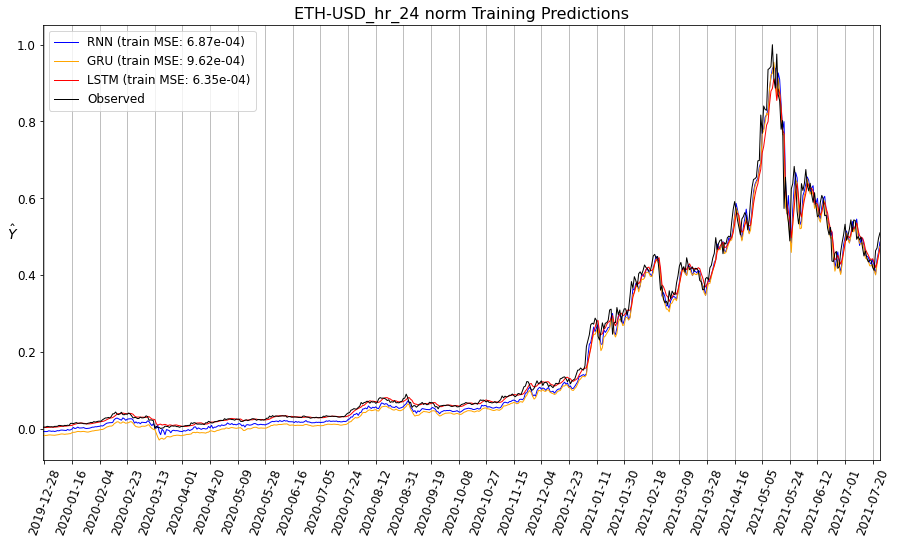

In [11]:
max_pts = 10**4
compare = params.keys()
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train_full[l:u])//max_pts) # Downsampling ratio for under `max_pts`
#                                         # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train_full[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title(f'{dataset} {scale} Training Predictions', fontsize=16)
plt.savefig(f'../data/figures/{scale}/{dataset}_{n_steps}_lag_multi_training_performance.png')

## Plot Testing Predictions (Multivariate)

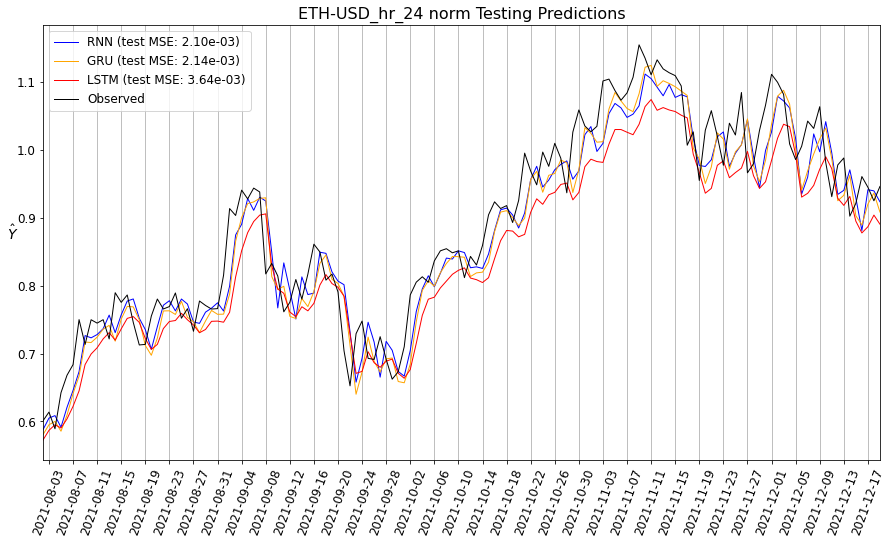

In [12]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
# l, u = (None, None) # lower and upper indices of range to plot 
# ds = max(1, len(y_train_full[l:u])//max_pts) # Downsampling ratio for under `max_pts`
#                                         # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title(f'{dataset} {scale} Testing Predictions', fontsize=16)
plt.savefig(f'../data/figures/{scale}/{dataset}_{n_steps}_lag_multi_testing_performance.png')

## Plot Training Error (Multivariate)

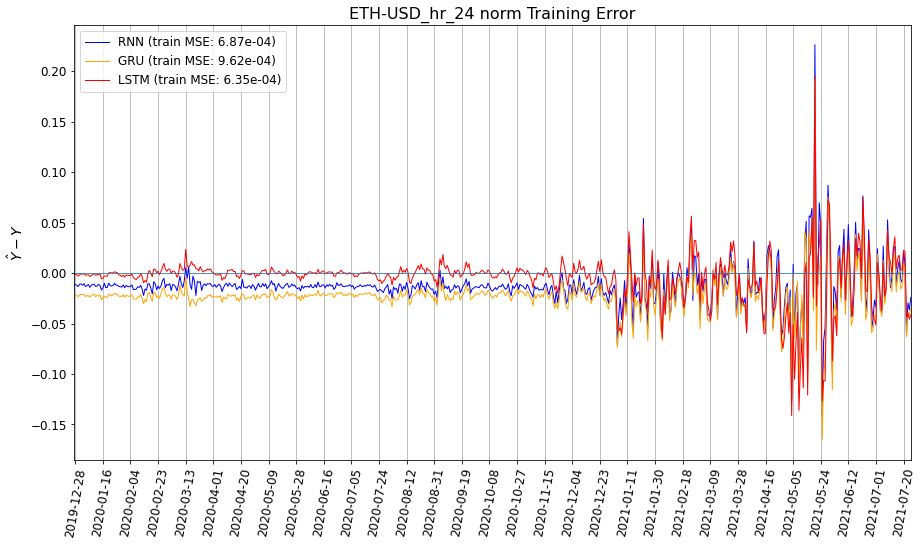

In [13]:
compare = params.keys()
# l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
# ds = max(1, len(y_train_full[l:u])//max_pts) # Downsampling ratio for under `max_pts`
#                                         # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train_full[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title(f'{dataset} {scale} Training Error', fontsize=16)
plt.savefig(f'../data/figures/{scale}/{dataset}_{n_steps}_lag_multi_training_performance_difference.png')

## Plot Testing Error (Multivariate)

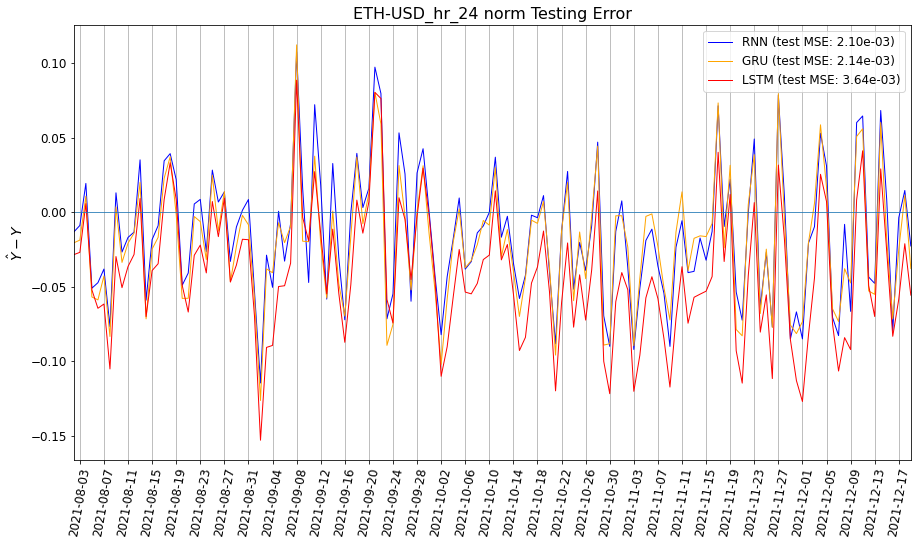

In [14]:
compare = params.keys()

fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title(f'{dataset} {scale} Testing Error', fontsize=16)
plt.savefig(f'../data/figures/{scale}/{dataset}_{n_steps}_lag_multi_testing_performance_difference.png')

# View Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006